# Sequence Processing with Recurrent Neural Networks

## Background

So far, we have seen how word vectors can be constructed from corpus statistics, and how they can be utilized to infer latent semantic content either in isolation (e.g. genders from names) or in relation to one another (e.g. similarities and analogies).

For tasks involving larger linguistic units such as phrases, sentences and dialogues, we need machinery capable of processing _sequences_ or _structures_ of words.

Recurrent Neural Networks (RNNs) are an example of such machinery. For this assignment, you will construct a recurrent neural network that will predict properties of the upcoming (not yet seen) text. You know this situation from language models, which try to predict the next word in a sequence given context. What language models do is provide a conditional probability distribution over the whole vocabulary of the upcoming word. Here, however, we will simplify our life. Rather than trying to predict the upcoming word, **we will construct a recurrent neural network that will predict the part-of-speech tag (POS tag) of the upcoming word.** That is, the network will build a conditional probability distribution over the full list of POS tags of the upcoming word given the preceding context.

Let's look at a few examples to make it clear what the model will be doing and to gauge intuion on how difficult this is. Sometimes, the task can be fairly easy. For instance, if the sentence starts as 'I want to...' then the next POS tag (the POS tag of the next word given this context) is very likely to be a verb in its base form (e.g., 'sleep'). Other times, it is harder. For instance, if the context is 'John left...' the continuation could be almost any POS tag, from the period (which has its own tag) to a preposition (as in 'John left at noon') through pronouns (as in 'John left us') to determiners (as in 'John left the city').

This task can be seen as simplified case of using an RNN as a language model. A good reference point for RNNs as language models and for RNNs as labellers of POS tags is in Jurafsky and Martin [Chapter 8](https://web.stanford.edu/~jurafsky/slp3/8.pdf).

You might wonder why anyone would bother modeling such prediction. One reason is that the resulting model can be seen as approximating human behavior, in this case, human behavior in reading and listening. It is a well-known fact that when we process text (or speech), we do not just passively wait for the incoming information. We are immediately interpreting and we predict what will be coming next. This prediction has various levels of abstraction: we might predict concrete words, but we also predict abstract properties of such words, such as gender or their phonological structures. The task that you do here can be seen as one step in this prediction process. We will try to see whether the resulting RNN model is in any way similar to humans.

We will take a gradual approach, first inspecting recurrent neural networks, then moving on to data processing using high-grade word vectors before finally moving to the problem at hand.

---

There are 10 tasks in this assignment. Each comes with its sub-tasks and point distribution. The total of points is 40.

---

You are greatly encouraged to add comments to your code describing what particular lines of code do (in general, a great habit to have in your coding life).
Additionally please follow these rules when submitting the notebook:

* Put all code in the cell with the `# YOUR CODE HERE` comment or `NotImplemented`.
* For theoretical questions, put your solution in the `YOUR ANSWER HERE` cell and keep the header(!).
* Don't change or delete any initially provided cells, either text or code, unless explicitly instructed to do so.
* Don't delete the comment lines `# TEST...` or edit their code cells. The test cells are for sanity checking. Passing them doesn't necessarily mean that your code is fine.
* Don't change the names of provided functions and variables or arguments of the functions.
* Don't clear the output of your code cells.
* Don't output unnecessary info (e.g., printing variables for debugging purposes). This clutters the notebook and slows down the grading. You can have print() in the code, but comment them out before submitting the notebook.
* Delete those cells that you inserted for your own debugging/testing purposes.
* Don't forget to fill in the contribution information.
* Test your code and **make sure we can run your notebook** in the colab environment.
* A single notebook file (without archiving) per group should be submitted via BB.

<font color="red">Following these rules helps us to grade the submissions relatively efficiently. If these rules are violated, a submission will be subject to penalty points.</font>

# <font color="red">Contributions</font>

Names of Group 64:
* Youssef Ben mansour
* Tim Kramer

Contributions:
* We both contributed equally to each exercise. We worked on each exercise independently and during the lab sessions, and then further compared and improved them. However, Youssef focussed a bit more contributing to c2 and Tim to c6 and c7.


## Recurrent Neural Networks
Recurrent Neural Networks are a particularly interesting class of neural networks. Unlike standard fully-connected networks that accept a fixed-size input and produce a fixed-size output over a predefined number of computational steps (i.e. network layers), RNNs instead operate on sequences of vectors.

Computationally, feedforward networks may be seen as a trainable (but parametrically fixed) function, whereas RNNs act as continuous, stateful programs operating on sequences of inputs.
Cognitively, this may be viewed as enhancing our system's perceptive and computational abilities with a notion of memory.
In the general case, this statefulness is captured by an intermediate hidden vector which is adjusted throughout the computation, affected by both the immediately previous version of itself __and__ the current input.

RNNs are nowadays established as the core machinery of neural sequence processing.

A simple recurrent network (SRN or Elman network) is described by the equations:
* $h_t = \theta_h (W_h x_t + U_h h_{t-1} + b_h ) $
* $y_t = \theta_y (W_y h_t + b_y) $

where (at timestep $t$) $x_t$, $h_t$, $y_t$ are the network's input, hidden and output representations respectively, $\theta_h$, $\theta_y$ are its hidden and output activation functions, and $W_h$, $U_h$, $b_h$, $W_y$, $b_y$ are the parametric tensors to be learned.

In [1]:
# Importing - all packages needed in this assignment

# numpy for data analysis - should be lower than 2.0, otherwise there are compatibility issues with spacy;

import pickle # pickle for loading existing python objects
from collections import Counter, defaultdict # counter for simple counting models

import numpy as np
import pandas as pd

# torch - for NNs
import torch
print(f"torch ver={torch.__version__}\nnumpy ver={np.__version__}")
from torch import FloatTensor, LongTensor
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

# sklearn for easy split of training and testing
from sklearn.model_selection import train_test_split

# matplotlib for plotting results
from matplotlib import pyplot as plt

# typing to indicate types in code
from typing import Tuple, List, Callable, Optional, Dict
torch.set_printoptions(precision=8) #to increase precision of printing floats

# spacy for pretrained vectors
import spacy
print(f"spacy ver={spacy.__version__}")

# tqdm to show progress bars during (long) loops
from tqdm import tqdm

torch ver=2.5.0+cu121
numpy ver=1.26.4
spacy ver=3.7.5


We will use the following function to concisely convert torch tensors to numpy arrays before printing tensors.

In [2]:
# Conversion between tensor and np
def tr2np(tensor):
    """Convert torch tensor into numpy array"""
    return tensor.detach().cpu().numpy()

In [3]:
# define a global variable for processing unit
# set it to cuda if gpu is available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

### Our own SRN
Let's make our own simple recurrent network from scratch, to get an idea of its inner workings. To make our life just a bit simpler, we will use `torch.nn.Linear` to model the internal transformations.

#### TASK 1
Complete the `mySRN` class, which is initialized with the input $d_i$, hidden $d_h$ and output $d_o$ dimensionalities, as well as two non-linear functions $\theta_h$ and $\theta_y$, and constructs an SRN implementing three `torch.nn.Linear` layers:
1. `x_to_h`: a layer that takes $x_t$ and produces $W_h x_t$
2. `h_to_h`: a layer that takes $h_{t-1}$ and produces $U_h h_{t-1} + b_h$
3. `h_to_y`: a layer that takes $h_t$ and produces $W_y h_t + b_y$

Implement the function `step` that performs a computational step, accepting $x_t$ and $h_{t-1}$ and producing $h_t$ and $y_t$.

Implement the function `forward` that accepts a List of inputs $X$, an initial hidden vector $h_{-1}$ and iteratively applies `step` until the input sequence is exhausted, returning a List of outputs $Y$ (of the same length as $X$).

<font color="red">_Hint_: Note that `x_to_h` does not have a bias term $b$, since we will incorporate it into `h_to_h`

In [16]:
# @title c1 [2pt]
# simple and slow RNN

class MySRN(torch.nn.Module):
    """
    SRN module, hand-coded.
    The dimension and activation argumenst are self-descriptive.
    device points to the device ('cpu' or 'cuda') on which the tensors and computations on them will be allocated.
    """

    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        hidden_activation: Callable[[FloatTensor], FloatTensor],
        output_activation: Callable[[FloatTensor], FloatTensor],
        device: str = 'cpu',
        seed: int = 42
    ) -> None:
        super().__init__()
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.device = device
        #
        torch.manual_seed(seed)
        self.x_to_h = torch.nn.Linear(input_dim, hidden_dim, bias=False)
        self.h_to_h = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.h_to_y = torch.nn.Linear(hidden_dim, output_dim, bias=True)
        # YOUR CODE HERE

    def step(self, x: FloatTensor, hprev: FloatTensor) -> Tuple[FloatTensor, FloatTensor]:
        """
        step performs a computational step, accepting x_t and hprev (h_{t-1}) and producing h_t and y_t
        """
        h_t = self.hidden_activation(self.x_to_h(x) + self.h_to_h(hprev))
        y_t = self.output_activation(self.h_to_y(h_t))

        return h_t, y_t

    def forward(self, X: List[FloatTensor], hprev: FloatTensor) -> List[FloatTensor]:
        """
        forward accepts a List of inputs X, an initial hidden vector hprev (h_{t−1}) and
        iteratively applies step until the input sequence is exhausted,
        returning a List of outputs Y (of the same length as X).
        """
        # for each output element y_t, detach it before appending to Y
        # YOUR CODE HERE
        Y = []
        for input in X:
            hprev, y_t = self.step(input, hprev)
            Y.append(y_t.detach())
        return Y

The following toy RNN helps you to verify whether your implementation is correct.  
Use the numbers below in the functions, and you can manually verify the output of the RNN.  
This manual check will help you to see whether you are understanding the calculations behind the RNN.

In [17]:
# TEST c1
# note that the default seed parameter makes output of the cell deterministic
# create our RNN with some short dimensions
my_rnn = MySRN(3, 2, 1, torch.nn.ReLU(), torch.nn.ReLU(), device='cpu')

# printing initilized weights and biases
print("X->H", "\nmatrix:\n", tr2np(my_rnn.x_to_h.weight), "\nbias:", my_rnn.x_to_h.bias)
print("H->H", "\nmatrix:\n", tr2np(my_rnn.h_to_h.weight), "\nbias:", tr2np(my_rnn.h_to_h.bias))
print("H->Y", "\nmatrix:\n", tr2np(my_rnn.h_to_y.weight), "\nbias:", tr2np(my_rnn.h_to_y.bias))

# running the RNN on a sample input of size 2 and an initial hidden vector
output = my_rnn.forward([FloatTensor([0,0,1]), FloatTensor([1,0,0])],
                         FloatTensor([1,1]))

print("output:\n", output)

X->H 
matrix:
 [[ 0.44140652  0.47920528 -0.13525727]
 [ 0.53036046 -0.1264995   0.11650391]] 
bias: None
H->H 
matrix:
 [[-0.3442585   0.41527155]
 [ 0.62334496 -0.5187534 ]] 
bias: [0.6146145  0.13234161]
H->Y 
matrix:
 [[0.5224168  0.09576388]] 
bias: [0.34095848]
output:
 [tensor([0.66232765]), tensor([0.94909447])]


In practice, we do not need to write our own functions for common RNN architectures.
Torch already provides the [necessary abstractions](https://pytorch.org/docs/stable/nn.html#recurrent-layers).

The [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN) wrapper implements highly optimized forward routines to compute the hidden representations of a full input sequence.

Some pointers:
* Unlike our naive implementation, RNN accepts a 3-dimensional tensor of shape (seq_len, batch_shape, input_dim) rather than a list of 2-dimensional tensors
* If no initial hidden state is provided, it defaults to a zero tensor
* The class produces just the RNN hidden states; it is up to us to define the `h_to_y` transformation on top of them
* The non-linearity argument is a string; our only two choices are either `"tanh"` or `"relu"` (shorthands for `torch.nn.Tanh` and `torch.nn.ReLU` respectively)

**Read the documentation (!) for further details.**

A brief example is given below.

In [18]:
rnn = torch.nn.RNN(input_size=16, hidden_size=48, nonlinearity="tanh")
X = torch.rand(10, 32, 16)
h, _ = rnn(X)
print(h.shape)

torch.Size([10, 32, 48])


So, for a random input tensor of shape (seq_len, batch_size, input_dim), we get back an output tensor of shape (seq_len, batch_size, hidden_dim).

In [19]:
del MySRN, rnn, X, h, my_rnn, output #, Uh_b, Wx, h1, y1

#### TASK 2
Create a new class, FastSRN, which uses the `RNN` wrapper and the `h_to_y` transformation.

In [85]:
# @title c2 [2pt]
# faster RNN

class FastSRN(torch.nn.Module):
    """
    SRN module using RNN class in torch.
    """

    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        output_activation: Callable[[FloatTensor], FloatTensor],
        hidden_activation: str = 'tanh',
        num_layers: int = 1,
        device: str = 'cpu',
        seed: int = 42
    ) -> None:
        super().__init__()
        self.device = device
        torch.manual_seed(seed)

        self.rnn = torch.nn.RNN(input_size=input_dim,
                                hidden_size=hidden_dim,
                                num_layers=num_layers,
                                nonlinearity=hidden_activation)

        self.h_to_y = torch.nn.Linear(hidden_dim, output_dim, bias=True)

        self.hidden_activation = hidden_activation
        self.output_activation = output_activation

    def forward(self, X:FloatTensor, hprev: Optional[FloatTensor]=None) -> FloatTensor:
        """
        forward accepts a List of inputs X, an initial hidden vector hprev (h_{t−1})
        and iteratively applies step until the input sequence is exhausted,
        returning a List of outputs Y (of the same length as X).
        """
        seq, _ = self.rnn(X,hprev)

        Y = []

        for i in seq:
          y = self.output_activation(self.h_to_y(i))
          Y.append(y)
        return torch.stack(Y,dim=0).to(self.device)

##### Testing the new implementation

Let's see our new implementation in action.

Initialize a random input tensor $X$ that would correspond to 32 sequences,  each of length 10, with each item having 16 features, and a `fastSRN` fit to process it, producing 42-dimensional hidden states and 2-dimensional output vectors for each sequence item.

Run the SRN on the tensor and make sure the output shape is as expected.

In [23]:
# TEST c2a
fast_srn = FastSRN(input_dim=16, hidden_dim=42, output_dim=2,
    output_activation=torch.nn.Softmax(dim=-1), device="cpu"
)
X = torch.rand(10, 32, 16) # if device='cuda', this needs to be moved to 'cuda'
y = fast_srn(X)
y.shape

torch.Size([10, 32, 2])

Again you can verify correctness of your implementation here, and as before, check whether it really does the computations what equations are describing.

In [24]:
# TEST c2b
torch.manual_seed(10)
# create our RNN with some short dimensions
fast_srn = FastSRN(3, 2, 2, output_activation=torch.nn.Softmax(dim=-1), hidden_activation='relu', device='cpu')

# printing initilized weights and biases
print("X->H", "\nmatrix:\n", tr2np(fast_srn.rnn.weight_ih_l0), "\nbias:",  tr2np(fast_srn.rnn.bias_ih_l0))
print("H->H", "\nmatrix:\n", tr2np(fast_srn.rnn.weight_hh_l0), "\nbias:", tr2np(fast_srn.rnn.bias_hh_l0))
print("H->Y", "\nmatrix:\n", tr2np(fast_srn.h_to_y.weight), "\nbias:", tr2np(fast_srn.h_to_y.bias))


# running the RNN on a sample input of size 2
output = fast_srn.forward(torch.FloatTensor([[[0,0,1]], [[1,0,0]]]))

print("output:\n", tr2np(output))

X->H 
matrix:
 [[ 0.5406104   0.5869042  -0.16565566]
 [ 0.6495563  -0.15492962  0.14268756]] 
bias: [0.6146145  0.13234161]
H->H 
matrix:
 [[-0.3442585   0.41527155]
 [ 0.62334496 -0.5187534 ]] 
bias: [0.5224168  0.09576388]
H->Y 
matrix:
 [[ 0.34095848 -0.09983712]
 [ 0.5450986   0.10451668]] 
bias: [-0.33010566  0.18024032]
output:
 [[[0.313369   0.686631  ]]

 [[0.25354943 0.7464506 ]]]


In [25]:
del fast_srn, X, y, output

You may have noticed a minor complication: in order to utilize batching, we need our input sequences to be of the same length.

This, however, is very rarely the case in practice. A common trick against this problem is _padding_; that is, appending zero tensors to all input sequences shorter than the maximum in-batch length to make them all equally long.

As usual, torch already does the hard work for us via [pad_sequence](https://pytorch.org/docs/stable/nn.html?highlight=pad%20_sequence#torch.nn.utils.rnn.pad_sequence). Given a list of $N$ 2-dimensional tensors, each of shape (seq\_len$_n$, input_dim), it will construct a 3-d tensor of shape ($max_{n \in N}${seq\_len$_n$}, N, input_dim).

An example:

In [26]:
x1 = torch.rand(1, 3)  # a sequence of 1, 3-dimensional item
x2 = torch.rand(4, 3)  # a sequence of 4, 3-dimensional items
x3 = torch.rand(2, 3)  # a sequence of 2, 3-dimensional items

X = torch.nn.utils.rnn.pad_sequence([x1, x2, x3])

# Can you guess what the shape of X is?
print(X.shape)

torch.Size([4, 3, 3])


Now compare the contents for better understanding.

In [27]:
for i in [x1, x2, x3]: print(i)
print(f"\n{'After combining':=^50}\n\n{X}")

tensor([[0.26963168, 0.44136357, 0.29692084]])
tensor([[0.83168548, 0.10531491, 0.26949483],
        [0.35881263, 0.19936377, 0.54719156],
        [0.00616044, 0.95155454, 0.07526588],
        [0.88601369, 0.58320957, 0.33764774]])
tensor([[0.80897498, 0.57792538, 0.90398169],
        [0.55465984, 0.34231341, 0.63434184]])

=================After combining==================

tensor([[[0.26963168, 0.44136357, 0.29692084],
         [0.83168548, 0.10531491, 0.26949483],
         [0.80897498, 0.57792538, 0.90398169]],

        [[0.00000000, 0.00000000, 0.00000000],
         [0.35881263, 0.19936377, 0.54719156],
         [0.55465984, 0.34231341, 0.63434184]],

        [[0.00000000, 0.00000000, 0.00000000],
         [0.00616044, 0.95155454, 0.07526588],
         [0.00000000, 0.00000000, 0.00000000]],

        [[0.00000000, 0.00000000, 0.00000000],
         [0.88601369, 0.58320957, 0.33764774],
         [0.00000000, 0.00000000, 0.00000000]]])


In [28]:
del x1, x2, x3, X, i

## Pretrained Word Embeddings
In the last assignment, we saw how to train our own word embeddings using a small toy corpus. Now, we will see how to easily get high-quality pretrained word vectors and how to utilize them for further downstream tasks.

We are going to use [spaCy](https://spacy.io/). SpaCy is a high-level NLP library that provides a ton of useful functionalities, but we will only focus on its pretrained embeddings for this assignment.

Before proceeding, [install spacy](https://spacy.io/usage) using your python package manager (e.g. `pip install spacy`), or it is already preinstalled if using the Colab environment.

SpaCy comes with a lot of different-size models for different languages.

We will need to download the large English model for the exercises to follow. You can do it by simply running the magic command below.

In [29]:
!python3 -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


After having downloaded the model, we can load it as follows (you may need to restart your notebook after the download is complete):

In [30]:
nlp = spacy.load("en_core_web_lg")

We can then use the loaded model to process a sentence and obtain its word vectors, a List of 300-dimensional numpy arrays. [More info](https://spacy.io/models/en#en_core_web_lg) about vectors coming with `en_core_web_lg`.  
We can also check similarities between the vectors, e.g., `words` is more similar to `sentence` than to `this`.

In [31]:
doc = nlp("this is a sentence of 7 words")  # the processed sentence
vectors = list(map(lambda x: x.vector, doc))  # its vectors
# vectors = [ t.vector for t in doc ] # or the same with list comprehension

print(f"We have {len(vectors)} vectors", end=", ")
print(f"each of shape {vectors[0].shape} and of type {type(vectors[0])}")

print(f"'{doc[6]}' is {doc[6].similarity(doc[3]):.2f} similar to '{doc[3]}' and {doc[6].similarity(doc[0]):.2f} similar to '{doc[0]}'")

We have 7 vectors, each of shape (300,) and of type <class 'numpy.ndarray'>
'words' is 0.51 similar to 'sentence' and 0.36 similar to 'this'


And then finally convert them into torch tensors.

In [32]:
torch_vectors = torch.tensor(np.array(vectors))
# torch_vectors = torch.tensor(vectors) # this is also fine but might get an efficiency warning from torch
print(torch_vectors.shape)

torch.Size([7, 300])


Or, in the case of multiple sentences:

In [33]:
# Example sentences.
sentences = ["This is a sentence", "This is another sentence."]

# Parallel processing with spacy.
docs = list(map(nlp, sentences))

# Convert each processed sentence into a list of vectors.
vectors = map(lambda doc: [word.vector for word in doc], docs)

# Convert each list of vectors into a 2-d torch tensor.
tensors = list(map(lambda sentence_vectors: torch.tensor(np.array(sentence_vectors)), vectors))
print(tensors[0].shape)

torch.Size([4, 300])


Given our pretrained embeddings, we may represent sentences as _sequences of pretrained vectors_, which is exactly the format expected by an RNN. (That is, to be clear, our pretrained embeddings will be used as input vectors for our RNN.)

### Examining the data
First, let's load and inspect our data files.

The pickle file contains three items:
1. `sentences`: a List of strings (sentences)
2. `postags`: a List of Lists of strings (POS tags)
3. `pos_to_int`: a Dictionary from strings to ints (mapping each POS tag to a unique identifier)

In [34]:
# Download files on the fly with the below two lines
!wget -nv https://naturallogic.pro/_files_/download/MLHVL/pos-rnn-data.zip
!unzip -n pos-rnn-data.zip

2024-11-09 14:44:57 URL:https://naturallogic.pro/_files_/download/MLHVL/pos-rnn-data.zip [2162187/2162187] -> "pos-rnn-data.zip" [1]
Archive:  pos-rnn-data.zip
  inflating: TEST.p                  
  inflating: TRAIN.p                 


In [35]:
import pickle
with open("TRAIN.p", "rb") as f:
    sentences, postags, pos_to_int = pickle.load(f)

Let's sanity check that we have the same number of sentences as pos tag annotations and for each sentence and annotation pair, the number of tokens and tags are the same.

In [36]:
assert all(list(map(lambda s, p: len(s.split()) == len(p), sentences, postags)))

Now, let us take a moment to understand the data a bit more.
Run the cell below with different values of `i` to get an idea of how the data looks like.

In [37]:
i = 2
for tok, tag in zip(sentences[i].split(), postags[i]):
    print(f"{tok}/{tag}", end=' ')

The/DT luxury/NN auto/NN maker/NN last/JJ year/NN sold/VBD 1,214/CD cars/NNS in/IN the/DT U.S./NNP 

In [38]:
del i, tok, tag, torch_vectors, vectors, f, doc, docs, tensors

#### TASK 3

The POS tags in this dataset are in the style of the Penn Treebank. Find the top 20 most common tags and summarise by plotting their frequencies, e.g., the histogram of the top 20 most frequent POS tags sitting on the x axis and y axis marking their raw counts. Find what these tags mean linguistically and state what the top 6 POS tags represent. See https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html for details.  
<font color="red">_Hint_: you can use pandas; the 7th and 8th most frequent tags are punctuation marks.</font>

<Axes: >

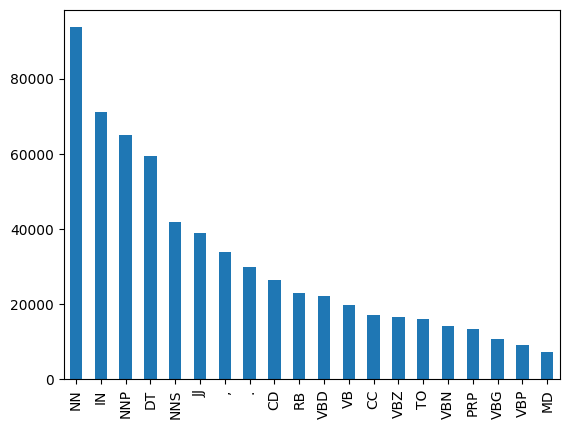

In [39]:
# @title c3.1 [1pt]

flattened_ags = pd.Series(np.concatenate(postags).flat)

top20 = flattened_ags.value_counts(dropna=False).head(20)

top20.plot(kind='bar')

We will explore the data some more, which will lead us to two baseline models on predicting POS tags. The first model would simply predicting the most frequent POS tag regardless of the input word sequence. We call such a model the most frequent tag (MFT) model.

Write a function that takes training and test sets of POS tags and returns (i) the score of the MFT model on the test set, and (ii) the MFT based on the training set.    
Note that the function doesn't take training and test sets of sentences as the MFT model doesn't make use of word sequences.  
<font color="red">_Hint_: you might want to use `Counter` from `collections` that facilitates counting itmes.</font>

In [40]:
# @title c3.2 [1pt]

def mft_baseline(pos_train: List[List[str]], pos_test: List[List[str]]) -> Tuple[float, str]:
    """
    Takes training and test sets of POS tags and returns
    (i) the score of the MFT model on the test set, and (ii) the MFT on the training set.
    """
    flattened_train = [tag for sentence in pos_train for tag in sentence]
    mft = Counter(flattened_train).most_common(1)[0][0]

    total_tags = sum(len(sentence) for sentence in pos_test)
    correct_predictions = sum(tag == mft for sentence in pos_test for tag in sentence)
    score = correct_predictions / total_tags

    return score, mft

In [41]:
# TEST c3.2
# testing the function on the sample input
mft_score, mft = mft_baseline(postags[:24_000], postags[24_000:])
print(f"mft_score = {mft_score}, where mft = {mft}")

assert mft_score > 0.10

mft_score = 0.1408964685014757, where mft = NN


Another baseline model to predict POS tag would assign the most frequent POS tag given the single previous word. This baseline is called the unigram baseline. We will explore how much data would be accounted for this way.  

Complete the function `unigram_baseline` below. It takes usual input: training and test sets, each represented with list of sentences and list of the corresonding POS tags. Note that unlike the MFT baseline, the unigram baseline takes words into account. The function returns (i) the score that the unigram model trained on the training set obtains on the test set, and (ii) the unigram model that is represented as a [`defaultdict`](https://docs.python.org/3/library/collections.html#collections.defaultdict), where he default value is the most frequent tag that is predicted for the words unseen in the training set, but seen in the test set.

In [43]:
# @title c3.3 [2pt]

def unigram_baseline(sen_train: List[str], pos_train: List[List[str]],
                     sen_test: List[str], pos_test: List[List[str]]) -> Tuple[float, defaultdict]:
    """
    Takes training and test sets, each represented with list of sentences and list of the corresonding POS tags.
    Note that unlike the MFT baseline, the unigram baseline takes words into account.
    """
    # you can reuse mft_baseline to get the most frequent tag

    _, mft = mft_baseline(pos_train, pos_test)

    # create unigram baseline model based on previous tag
    pos_tag_counts = defaultdict(lambda: defaultdict(int))

    for pos_tags in pos_train:
        for i in range(1, len(pos_tags)):
            prev_tag = pos_tags[i - 1]
            current_tag = pos_tags[i]
            pos_tag_counts[prev_tag][current_tag] += 1

    # for each model, also store next mft
    unigram = defaultdict(lambda: mft)
    for prev_tag, next_tags in pos_tag_counts.items():
        unigram[prev_tag] = max(next_tags, key=next_tags.get)

    # evaluation
    correct_predictions = 0
    total_predictions = 0

    for pos_tags in pos_test:
        for i in range(1, len(pos_tags)):
            prev_tag = pos_tags[i - 1]
            actual_tag = pos_tags[i]
            predicted_tag = unigram[prev_tag]
            if predicted_tag == actual_tag:
                correct_predictions += 1
            total_predictions += 1

    score = correct_predictions / total_predictions if total_predictions > 0 else 0

    return score, unigram

In [44]:
# TEST c3.3
# testing the function on the sample input
unigram_score, unigram = unigram_baseline(sentences[:24_000], postags[:24_000], sentences[24_000:], postags[24_000:])
print(f"unigram_score = {unigram_score}")

assert unigram_score > 0.30

unigram_score = 0.3153731968180261


In [45]:
del mft_score, mft, unigram_score, unigram

### Tensorizing sentences
Next, we need to convert our data to numeric form. We will convert sentences to their tensor format, as done earlier.

<div class="alert alert-block alert-info">
<b>Important!</b>
Since the sentences are pre-tokenized with whitespace (e.g., <code>One , two , and three .</code> instead of <code>One, two, and three.</code>), we need to change the processing call to ensure the output vectors are aligned with our tokenization (otherwise SpaCy will tokenize it in its own way and might break the correspondence between tokens and POS tags).
</div>

In [46]:
docs = [ spacy.tokens.doc.Doc(nlp.vocab, words=sentence.split()) for sentence in sentences ]

doc_vectors = [ np.array([word.vector for word in doc]) for doc in docs ]
doc_tensors = [ torch.tensor(sentence_vectors) for sentence_vectors in doc_vectors ]

print(doc_tensors[1].shape)

torch.Size([5, 300])


Similarly, we will use pos_to_int to convert the POS sequences into tensors.

In [47]:
pos_numeric = [ np.array([pos_to_int[pos] for pos in pos_sequence]) for pos_sequence in postags ]
pos_tensors =  [ torch.tensor(pos_num_sequence) for pos_num_sequence in pos_numeric ]

print(pos_tensors[1].shape)
print(pos_tensors[1])

torch.Size([5])
tensor([12, 12, 26, 12, 14])


In [48]:
del doc_vectors, docs, pos_numeric

Finally, we also need to prepare for our task, which is **predicting** the POS tag. Right now, each element in doc\_tensors is a 2-dimensional tensor with rows corresponding to the vectors of the words in a sentence, and each element in pos\_tensors is a one-dimensional tensor with components representing the indices of the POS tag of the words. If we used these data for our model as it is, the model would not predict a tag based on the preceding words, but it would do a simple sequence POS-tag labelling (see Jurafsky and Martin [Chapter 8](https://web.stanford.edu/~jurafsky/slp3/8.pdf) for sequence labelling).

What we need instead is that the tensor elements of `doc_tensors` start their rows at the first word but ends at the last but one word (because the last word triggers no prediction). Conversely, the output tensor elements of `pos_tensors` should only start at the tag of the second word and go to the end (the first word will create the first context for predictions about the POS tag of the second word, words 1 and 2 will be the context to predict the POS tag of the third word etc.).

In a nutshell, to model POS tagging of upcoming words, we will use sequence labeling (like the standard POS tagging does), but the left-hand side context needs to exclude the upcoming word $w_t$ when predicting a POS tag $p_t$.

#### TASK 4

Create new lists, doc\_tensors\_predict and pos\_tensors\_predict, which will have the information as is described in the paragraph above.

In [49]:
# @title c4.1 [1pt]

# Modifying vectors for the prediction task.
doc_tensors_predict = [tensor[:-1] for tensor in doc_tensors]
pos_tensors_predict = [tensor[1:] for tensor in pos_tensors]

# YOUR CODE HERE

In [50]:
# TEST c4.1
# the following tests establish that doc_tensor and doc_tensors_predict are related
assert np.all(np.array(doc_tensors[0][43] == doc_tensors_predict[0][43]))
assert doc_tensors[3].shape[0] == doc_tensors_predict[3].shape[0] + 1
assert doc_tensors[3].shape[1] == doc_tensors_predict[3].shape[1]
assert np.array(pos_tensors[2][-1] == pos_tensors_predict[2][-1])

In the tutorial, we saw how to split our dataset into a training and a validation set.

We will do the same here, splitting the sentences, POS tags and their corresponding tensors into a training and a validation set.  
For the sake of determinism of the training, while splitting data, we set shuffling `random_state` to 42 and select 0.2 of the data for validation.

In [51]:
sentences_train, sentences_val, postags_train, postags_val, X_train, X_val, Y_train, Y_val \
    = train_test_split(sentences, postags, doc_tensors_predict, pos_tensors_predict, test_size=0.2, random_state=42)

After we have defined the training and validation sets, we can use the defined functions to calculate the scores of MFT and unigram baseline models.

In [52]:
# MFT baseline
mft_score, mft = mft_baseline(postags_train, postags_val)
print(f"mft_score = {mft_score}, where mft = {mft}")

mft_score = 0.14045150489117786, where mft = NN


In [53]:
# Unigram baseline
unigram_score, unigram = unigram_baseline(sentences_train, postags_train, sentences_val, postags_val)
print(f"unigram_score = {unigram_score}")

unigram_score = 0.3128524131205813


### Datasets and Padding

Following along the tutorial, we will wrap our tensors into a `Dataset` ([link](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)) and a `DataLoader` ([link](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)).

Since our data are not Tensors but rather Lists of Tensors of uneven lengths, we need to write our own Dataset wrapper.
The wrapper only needs to implement two functions; `__len__`, which expects no arguments and returns the number of samples in the dataset, and `__getitem__`, which accepts an index `idx` and returns the input-output pair `X[idx]`, `Y[idx]`.

Similarly, the Dataloader needs to process the list of input-output pairs produced by the Dataset using `pad_sequence`, as seen earlier.

We will fill in the code for `UnevenLengthDataset` class, implementing its two core functions.

Then, we complete the function `pad_batch` which takes a list of (x$_i$, y$_i$) pairs and produces the pair of their paddings: (X, Y).

Given the two, the `DataLoader` object can iterate over the Dataset yielding uniform batches ready to be consumed by an RNN.

In [54]:
class UnevenLengthDataset(Dataset):

    def __init__(self, X: List[FloatTensor], Y: List[LongTensor]) -> None:
        self.X = X
        self.Y = Y
        assert len(X) == len(Y), f"different size of X {len(X)} and Y {len(Y)}"

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int) -> Tuple[FloatTensor, LongTensor]:
        return self.X[idx], self.Y[idx]


def pad_batch(batch: List[Tuple[FloatTensor, LongTensor]]) -> Tuple[FloatTensor, LongTensor]:
    first_item_padded = pad_sequence([item[0] for item in batch])
    second_item_padded = pad_sequence([item[1] for item in batch])
    return first_item_padded, second_item_padded

In [55]:
BATCH_SIZE = 32 # don't change this value

train_dataset = UnevenLengthDataset(X_train, Y_train)
train_dataloader = DataLoader(
    train_dataset,
    collate_fn=pad_batch,
    shuffle=True, # data will be reshuffled at every epoch
    batch_size=BATCH_SIZE
)

val_dataset = UnevenLengthDataset(X_val, Y_val)
val_dataloader = DataLoader(
    val_dataset,
    collate_fn=pad_batch,
    shuffle=False,
    batch_size=BATCH_SIZE
)

What does a batch look like, shape-wise? Get the first element of `train_dataloader` to find out.  
Try to understand what each number in the shape means.  
<font color="red">_Hint_: 41 is the length of a sequence in the batch, but why 41?</font>

In [56]:
# without the seed, every time you run this cell, it will give a random batch
torch.manual_seed(0)
for batch_x, batch_y in train_dataloader:
    print(batch_x.shape)
    print(batch_y.shape)
    break

torch.Size([41, 32, 300])
torch.Size([41, 32])


In [57]:
del batch_x, batch_y

### Utility functions

Remember how we defined our training and validation functions in the torch intro notebook?

You will need to do the same here.
Note that while you can use the code from the tutorial for guidance, just copying it won't do the trick; unlike a feedforward net, a recurrent network produces a 3rd order output tensor of shape (max_seq_len, batch_size, num_output_classes).

Similarly, our target Y is a 2nd order tensor of shape (max_seq_len, batch_size).

You will need to properly treat the extra dimension of both the output and the target, since loss functions expect an order 2 output tensor and an order 1 target tensor.

The functions `accuracy` and `measure_accurace`, which will be needed during evaluation, are already provided to you.

In [58]:
def accuracy(predictions: LongTensor, truth: LongTensor, ignore_idx: int) -> Tuple[int, int]:
    """
    Compute the total count of non-ignored values and total count of correctly predicted values.

    :param predictions: the network's predictions
    :param truth: the true output labels
    :param ignore_idx: the output padding value, to be ignored in accuracy calculation
    :return the total count of non-ignored values, the total count of correctly predicted values
    """
    correct_words = torch.ones(predictions.size())
    # Zero out the incorrectly predicted values.
    correct_words[predictions != truth] = 0
    # Mark with 1 the values that need to be ignored.
    correct_words[truth == ignore_idx] = 1
    # Calculate the total count of correctly predicted values, incl. the ignored ones.
    num_correct_words = correct_words.sum().item()
    # Calculate the number of the values to be ignored.
    num_masked_words = len(truth[truth == ignore_idx])
    #
    count_non_ignored = predictions.shape[0] * predictions.shape[1] - num_masked_words
    count_correct = num_correct_words - num_masked_words
    return count_non_ignored, count_correct


def measure_accuracy(network: torch.nn.Module, dataloader: DataLoader, device: str) -> float:
    """
    Compute the network's accuracy across all batches.

    :param network: the trained network
    :param dataloader: the dataloader for the validation data
    :param device: the device to store the data on ("cpu" or "cuda")
    :return the network's accuracy
    """
    correct = 0
    total = 0
    # Iterate over the batches.
    for x_batch, y_batch in dataloader:
        # Get the network predictions.
        pred = network(x_batch.to(device))
        # Compute the values to measure accuracy for the current batch.
        # note that pos tags are mapped to numbers 1..48 and we can safely use 0 for making dummy padding slots
        local_total, local_correct = accuracy(pred.argmax(dim=-1), y_batch.to(device), ignore_idx=0)
        # Update the total counts.
        correct += local_correct
        total += local_total
    # Compute the final accuracy across all batches.
    acc = correct/total
    return acc

In [59]:
# If you want to understand how accuracy works, you can verify these toy input/output pairs
print(accuracy(LongTensor([[1,2,0,0], [3,4,5,0]]), LongTensor([[1,3,0,0], [1,4,5,0]]), ignore_idx=0))
print(accuracy(LongTensor([[1,2,0,0], [3,4,5,0]]), LongTensor([[1,3,0,0], [1,4,5,0]]), ignore_idx=9))

(5, 3.0)
(8, 6.0)


#### TASK 5

Complete the functions `train_batch`, `train_epoch`, `eval_batch` and `eval_epoch`.

In [71]:
# @title c5 [3pt]

def train_batch(
    network: torch.nn.Module,
    X_batch: FloatTensor,
    Y_batch: LongTensor,
    loss_fn: Callable[[FloatTensor, FloatTensor], FloatTensor],
    optimizer: torch.optim.Optimizer
) -> float: #batch-specific loss
    network.train()
    optimizer.zero_grad()
    predictions = network(X_batch)
    loss = loss_fn(predictions.view(-1, predictions.shape[-1]), Y_batch.view(-1))
    loss.backward()
    optimizer.step()
    return loss.item()

def train_epoch(
    network: torch.nn.Module,
    dataloader: DataLoader,
    loss_fn: Callable[[FloatTensor, FloatTensor], FloatTensor],
    optimizer: torch.optim.Optimizer,
    device: str
) -> float: #epoch's loss
    tloss = 0.0
    for x_batch, y_batch in dataloader:
        tloss += train_batch(network, x_batch.to(device), y_batch.to(device), loss_fn, optimizer)
    return tloss/len(dataloader)

def eval_batch(
    network: torch.nn.Module,
    X_batch: FloatTensor,
    Y_batch: LongTensor,
    loss_fn: Callable[[FloatTensor, LongTensor], FloatTensor]
) -> float: #batch-specific loss
    network.eval()
    with torch.no_grad():
        predictions = network(X_batch)
        loss = loss_fn(predictions.view(-1, predictions.shape[-1]), Y_batch.view(-1))
    return loss.item()


def eval_epoch(
    network: torch.nn.Module,
    dataloader: DataLoader,
    loss_fn: Callable[[FloatTensor, LongTensor], FloatTensor],
    device: str
) -> float: #epoch's loss
    tloss= 0.0
    for X_batch, Y_batch in dataloader:
        tloss += eval_batch(network, X_batch.to(device), Y_batch.to(device), loss_fn)
    return tloss/len(dataloader)

### Training your SRN model

#### TASK 6

Complete `training_model` function that defines a simple recurrent network, trains it on the raining set and evaluates on the validation set.

In the body of the function, define a simple recurrent network, with input size compatible with the vector dimensionality, output size compatible with the number of output classes (the number of different POS tags + 1 due to using 0 as padding in pos tag annotations) and a pre-defined hidden size. Don't forget to use `FastSRN` which was defined previously.

<ins>Choose an appropriate combination of output activation and loss function</ins> (consider the task at hand and refer to the documentation or the tutorial/warm-up notebook if in doubt).

Then instantiate an optimizer over your network and train the network for a specified number of epochs, measuring and printing all four metrics at the end of each epoch: for train and validation sets, loss and accuracy values.

<font color="red">_Hint_: Use `measure_accuracy` (defined earlier) to obtain accuracy. For the debugging you can try shorter hidden vectors and a single epoch.

In [87]:
# @title c6.1 [4pt]
def training_model(nn_unit, num_epochs: int, hidden_dim: int=512,
                   num_layers: int=1, device: str='cpu', seed: int=0) -> tuple:
    """
    The code to train the model.
    model is an object of torch.nn.Module, for example, srn.
    num_epochs specifies how many epochs should be used for training
    The function should train the model for the specified number of epochs.
    It returns: train_losses (as a list), validation losses (as a list), train accuracies (as a list) and validation accuracies (as a list)
    """
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    i= 300
    h = hidden_dim
    o= len(pos_to_int) + 1
    output_activation = torch.nn.LogSoftmax(dim=-1)

    srn = nn_unit(
        input_dim=i,
        hidden_dim=h,
        output_dim=o,
        output_activation=output_activation,
        num_layers=num_layers,
        device=device,
        seed=seed)

    srn.to(device)

    opt = torch.optim.Adam(srn.parameters(), lr=0.001)
    loss_fn = torch.nn.NLLLoss(ignore_index=0) # choice depends on the output_activation value of FastSRN

    torch.manual_seed(seed)

    for t in range(num_epochs):

        train_loss = train_epoch(srn, train_dataloader, loss_fn, opt, device)
        val_loss = eval_epoch(srn, val_dataloader, loss_fn, device)
        train_acc = measure_accuracy(srn, train_dataloader, device)
        val_acc = measure_accuracy(srn, val_dataloader, device)

        print(f"Epoch {t}")
        print(f"\tTraining / Validation Loss:     {train_loss} / {val_loss}")
        print(f"\tTraining / Validation Accuracy: {train_acc} / {val_acc}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)


    return srn, train_losses, val_losses, train_accuracies, val_accuracies

In [88]:
# TEST c6.1
srn, train_losses, val_losses, train_accuracies, val_accuracies = \
    training_model(FastSRN, 10, device=DEVICE) # feel free to change device value
# Don't clear the output of this cell!

Epoch 0
	Training / Validation Loss:     2.0013376207541156 / 1.8997151700277177
	Training / Validation Accuracy: 0.4323566182215971 / 0.4225890420654456
Epoch 1
	Training / Validation Loss:     1.8487304264346496 / 1.8552978883975397
	Training / Validation Accuracy: 0.44899007657446477 / 0.43380334856360936
Epoch 2
	Training / Validation Loss:     1.7945617071050681 / 1.8285187817124462
	Training / Validation Accuracy: 0.45960696983903737 / 0.44127431011568197
Epoch 3
	Training / Validation Loss:     1.7582188776786754 / 1.8200163178973727
	Training / Validation Accuracy: 0.46733473980309426 / 0.44550523360517147
Epoch 4
	Training / Validation Loss:     1.7316292401181153 / 1.8104216453259585
	Training / Validation Accuracy: 0.47143303641193934 / 0.4446244465590324
Epoch 5
	Training / Validation Loss:     1.7074081147743376 / 1.8117156747787717
	Training / Validation Accuracy: 0.4769964056883888 / 0.4453400860340204
Epoch 6
	Training / Validation Loss:     1.6878316001386833 / 1.80201

Plot the loss and accuracy curves for the training and validation sets. Set the x-axis for epoch number and y-axis for loss/accuracy values. Do this with the help of `plot_loss_accuracy` function. It is a good idea to wrap the plotting in a function as we will use it later too.

In [89]:
# @title c6.2 [1pt]
# Your loss plotting here: x-axis for epochs and y-axis for train and validation losses

def plot_loss_accuracy(train_losses: List[float], val_losses: List[float],
                       train_accuracies: List[float], val_accuracies: List[float],
                       baseline_accuracy: int) -> None:
    """
    Display two plots, one for the loss curves for the training and validation sets
    and the other for the accuracy curves.
    (!) Mark the baseline accuracy as a horizontal line.
    The function returns nothing, but displays the plots.
    """
    epochs = range(1, len(train_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    ax1.plot(epochs, train_losses, label="Training Loss", color='blue', marker='o')
    ax1.plot(epochs, val_losses, label="Validation Loss", color='orange', marker='o')
    ax1.set_title("Loss Over Epochs")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(epochs, train_accuracies, label="Training Accuracy", color='green', marker='o')
    ax2.plot(epochs, val_accuracies, label="Validation Accuracy", color='red', marker='o')
    ax2.axhline(y=baseline_accuracy, color='purple', linestyle='--', label="Baseline Accuracy")
    ax2.set_title("Accuracy Over Epochs")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend()

    plt.tight_layout()
    plt.show()

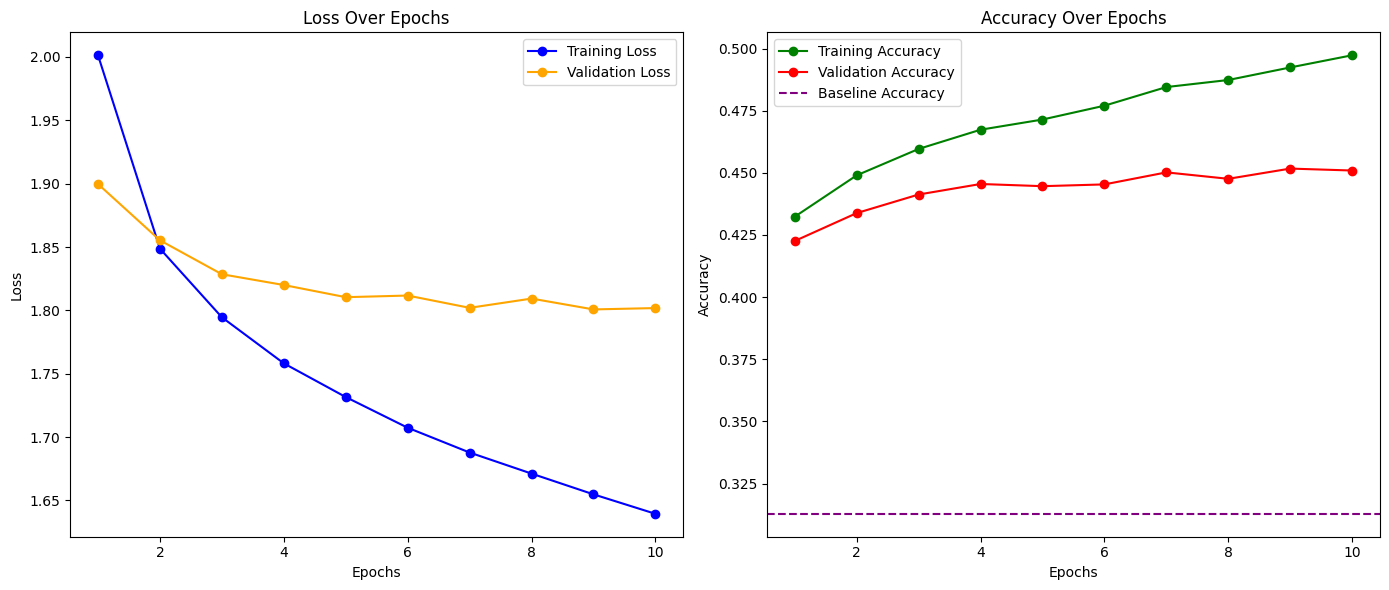

In [90]:
# TEST c6.2
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies,
                   unigram_score)
# Don't clear the output of this cell!

##### i6.3 [2pt]

You should get accuracy above the baseline models discussed in Section 3 and 4. If your accuracy is lower than that, something is wrong.

However, even though you beat the baseline model, you probably noticed that the accuracy is not very high. Most likely, it is below 50 percent on the validation set. Yet, POS tagging is basically a solved task nowadays - POS taggers usually have accuracy around 98 or 99 percent. Why is it that this model has a much lower accuracy? Say in a few sentences why.

**ANSWER**:
The reason state-of-the-art POS taggers achieve accuracies of around 98 to 99 percent, while our RNN model struggles, is because for succesful POS tagging, it is important for a model to capture long term dependencies in sequences. The POS tag of a word can be influenced by other words that are either close or far away in the sequence. Therefore, successful POS tagging requires a model capable of effectively handling these long dependencies and contexts. This introduces an issue for a simple RNN: due to its architecture, it struggles with the **vanishing gradient problem** (exponential decay of gradient weights), which limits the RNN’s ability to succesfully use dependency relationships over longer sequence distances. As a result, a simple RNN model, like one we designed for this assignment, is inherently limited compared to state-of-the-art POS taggers, which use more advanced architectures.


### LSTM

So far, we only worked with a simple recurrent neural network (which only had a single hidden layer). There are, however, many other more elaborated recurrent neural networks. One such recurrent neural network is LSTM (long short-term memory), which was developed mainly to battle one issue that simple RNNs battle with: the fact that gradient tends to vanish, making it hard for simple RNNs to update its weights across long sequences.

#### TASK 7

Implement an LSTM model. For this task, you can use the class `torch.nn.LSTM`. Before the implementation, make sure to check more details on ([link](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)). A few more notes: the code for your class should be similar to `FastSRN` but there is no specification for `hidden_activation` because activation across layers is already specified in the pytorch class. Second, make sure that you are using the unidirectional LSTM (if you used the bidirectional one, you would be predicting a POS tag based on preceding and following words, which is not what we want).

In [91]:
# @title c7.1 [1pt]

class LSTMPredTag(torch.nn.Module):
    """
    LSTM module for predictions of POS tags using LSTM class in torch.
    """

    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        output_activation: Callable[[FloatTensor], FloatTensor],
        num_layers: int = 1,
        device: str = 'cpu',
        seed: int = 42
    ) -> None:
        super().__init__()
        self.device = device
        torch.manual_seed(seed)

        self.lstm = torch.nn.LSTM(input_size=input_dim,
                                  hidden_size=hidden_dim,
                                  num_layers=num_layers)

        self.h_to_y = torch.nn.Linear(hidden_dim, output_dim, bias=True)

        self.output_activation = output_activation

    def forward(self, X:FloatTensor, hprev: Optional[FloatTensor]=None) -> FloatTensor:
        """
        forward accepts a List of inputs X, an initial hidden vector hprev (h_{t−1}) and iteratively applies step until the input sequence is exhausted, returning a List of outputs Y (of the same length as X).
        """
        lstm_out, _ = self.lstm(X, hprev)
        Y = self.h_to_y(lstm_out)

        # Apply output activation function
        if self.output_activation:
            Y = self.output_activation(Y)

        return Y

Now, you can proceeed in the same way as with your RNN model.  
Note that the arguments of `training_model` function was selected in such a way that the function can also accept `LSTMPredTag` and train LSTM.

In [92]:
# TEST c7.1
lstm, train_losses, val_losses, train_accuracies, val_accuracies = \
    training_model(LSTMPredTag, 10, device=DEVICE) # feel free to change device value
# Don't clear the output of this cell!

Epoch 0
	Training / Validation Loss:     1.920680460393034 / 1.7971304226173925
	Training / Validation Accuracy: 0.46621933114549147 / 0.45104160932376003
Epoch 1
	Training / Validation Loss:     1.7224375843212305 / 1.7378307278194125
	Training / Validation Accuracy: 0.4958782622284732 / 0.46665985105261915
Epoch 2
	Training / Validation Loss:     1.6393600141765265 / 1.7104482625527357
	Training / Validation Accuracy: 0.5166080637599625 / 0.4756328690851611
Epoch 3
	Training / Validation Loss:     1.5726056743141832 / 1.7007935375132888
	Training / Validation Accuracy: 0.5334134239724957 / 0.47738657900738446
Epoch 4
	Training / Validation Loss:     1.513311479739006 / 1.7005889415740967
	Training / Validation Accuracy: 0.5508829504610095 / 0.48075244379084453
Epoch 5
	Training / Validation Loss:     1.457820209130546 / 1.7047807678343758
	Training / Validation Accuracy: 0.5696808095014846 / 0.48057943204963866
Epoch 6
	Training / Validation Loss:     1.4051574637558286 / 1.719946626

In [ ]:
# Let's plot the scores using the previously defined function
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, unigram_score)
# Don't clear the output of this cell!

If everything is correct, your LSTM model should beat your SRN model on both training and validation datasets (probably more so on the former).

By tweaking certain hyperparameters in the network and its training, we can get better performance on the validation set. Your task is to experiment with different values for hyperparameters that are supported by `training_model` function: neural newtork unit, hidden dimension, the number of hidden layers, and the nuber of epochs.  
After finding the combination of values that gives the highest accuracy on the validation set, provide the values below.  
Don't provide any code that you used to find the optimal combinatin of the values.  
Run the cell below with the optimal argument values and keep the output and plot. The score of your best model will be defined as the accuracy score on the validation set after the final epoch training.

Bonus points 5, 3, and 2 will be given to the groups whose best score will make to the top three.

<font color="red">**Just fill in the optimal values that you found, train the model and plot the scores!**</font> No need to submit any other code.

In [96]:
# @title c7.2 [*]
# training teh best model
best_model, train_losses, val_losses, train_accuracies, val_accuracies = \
    training_model(LSTMPredTag, # choose the network class
                   num_epochs=5, # max 10
                   hidden_dim=256, # whatever value you want
                   num_layers=5, # you can also have as many hidden layers as you want
                   device=DEVICE) # you should want gpu here
print(f"The best performance accuracy = {val_accuracies[-1]}")
# Don't clear the output of this cell!

Epoch 0
	Training / Validation Loss:     2.579294802810972 / 2.225085448966455
	Training / Validation Accuracy: 0.35467651195499295 / 0.3510801437570286
Epoch 1
	Training / Validation Loss:     2.0942985158882395 / 2.0155521688007174
	Training / Validation Accuracy: 0.41092553523988123 / 0.40108840113558614
Epoch 2
	Training / Validation Loss:     1.939713426931015 / 1.9290414159260099
	Training / Validation Accuracy: 0.43709954680418817 / 0.42306089226873445
Epoch 3
	Training / Validation Loss:     1.8606984511116482 / 1.8819162359944097
	Training / Validation Accuracy: 0.45406118143459917 / 0.43524249168364015
Epoch 4
	Training / Validation Loss:     1.8064985322636484 / 1.8520076224412867
	Training / Validation Accuracy: 0.4691025941553368 / 0.4449154208510605
The best performance accuracy = 0.4449154208510605


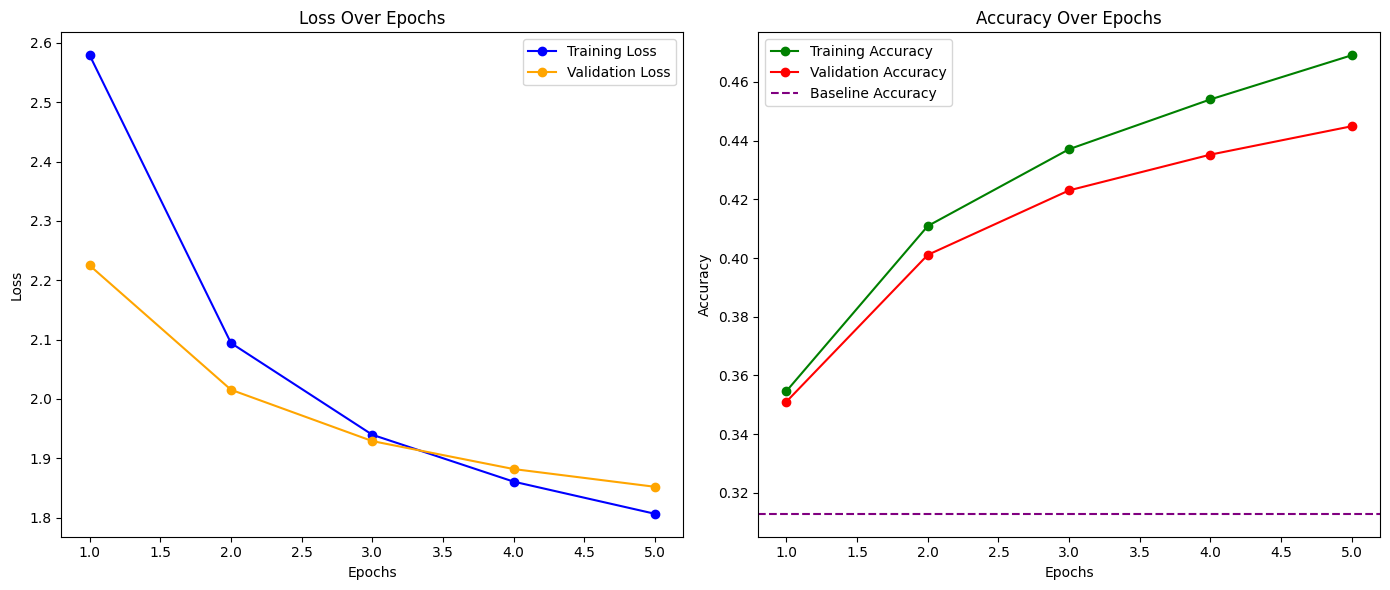

In [97]:
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, unigram_score)
# Don't clear the output of this cell!

### Exploring the models

We will now start exploring the models. We will start with the error analyis, in which we will find sentences from the validation set where the network predicted wrong POS tags.

#### TASK 8

Complete the function `predict_and_contrast` that returns, for a list of sentences, a list of lists of (word, true_tag, predicted_tag) triplets when the prediction of the model does not correspond to the actual tag, and a tuple (word, true_tag) when the prediction is right. Note that for the first word in a sentence, the model makes no predictions - you can collect the first word along with `None` as its tag.

Concretely, for `['John sleeps .']`, assuming the model predicts VBZ and IN, the output should be:  
`[[('John', None), ('sleeps', 'VBZ'), ('.', '.', 'IN')]]`.

In [98]:
# @title c8.1 [3pt]

def predict_and_contrast(nn: torch.nn.Module, sentences: list, tags: list, sent_vec: list, tag2idx: dict) -> list:
    """
    :param nn: the network representing a POS tagger
    :param sentences: the list of sentences
    :param tags: a list of list of tags (aligned with sentences)
    :param sent_vec: sentences with vectorized tokens
    :param tag2idx: mapping of tags to indices
    :param device: device for computation, defaults to the global DEVICE value
    returns a list of sentences, where sentences are a list of tuples:
        (token, tag) for correctly tagged tokens and
        (token, reference_tag, predicted_tag) for wrongly tagged tokens
    """
    int_to_pos = {v: k for k, v in tag2idx.items()}
    int_to_pos[0] = 'None' # default None for index 0

    all_predictions = []

    nn.eval()
    with torch.no_grad():
        for i, (sentence, true_tags, vec) in enumerate(zip(sentences, tags, sent_vec)):
            if len(sentence) == 0 or vec.size(0) == 0:
                all_predictions.append([])
                continue

            sentence_result = []
            vec = vec.to(DEVICE)

            # get model predictions
            predictions = nn(vec.unsqueeze(0))
            predicted_tags = torch.argmax(predictions, dim=-1).squeeze(0)

            words = sentence.split()

            # iteration through words and sentences
            for j, word in enumerate(words):
                if j < len(true_tags):
                    true_tag = true_tags[j]
                    if j < len(predicted_tags):
                        predicted_tag_idx = predicted_tags[j].item()
                        predicted_tag = int_to_pos.get(predicted_tag_idx, 'None') #special case for None
                        if true_tag == predicted_tag:
                            sentence_result.append((word, true_tag))
                        else:
                            sentence_result.append((word, true_tag, predicted_tag))
                    else:
                        sentence_result.append((word, true_tag, None))

            all_predictions.append(sentence_result)

    return all_predictions

In [99]:
# it is up to you which model to use here: srn, lstm, or best_model
tok_gold_pred = predict_and_contrast(lstm, sentences_val, postags_val, X_val, pos_to_int)

If you want to sanity check the implementation of the function. You could test whether you will get the same accuracy score from `tok_gold_pred` as the model got during the training-validation phase.

In [100]:
# TEST c8.1
# Don't clear the output of this cell!
for s in tok_gold_pred[37:39]: # feel free to change the slice indices
    print(' '.join([ f"{t[0]}|{t[1]}" if len(t) < 3 else f"{t[0]}|{t[1]}|{t[2]}" for t in s ]))
    # we print just one tag when it is guessed correctly, two tags (true and predicted) when the model fails

Mr.|NNP Melloan|NNP 's|POS|NN column|NN|IN was|VBD|DT right|RB on|IN|DT the|DT|NN money|NN|IN ,|,|IN but|CC|PRP I|PRP|VBP wish|VBP|PRP it|PRP|VBZ could|MD|VB have|VB|VBN gone|VBN|TO one|CD|IN step|NN|RP further|RBR|, .|.|None
How|WRB|MD unprofessional|JJ|NNS we|PRP|VBP must|MD|VB have|VB|VBN appeared|VBN|TO to|TO|VB the|DT|NN outside|JJ|DT world|NN|RB --|IN|NNP how|WRB|RB incompetent|JJ|, at|IN|DT risk|NN|VBG assessment|NN|IN and|CC|NNP evaluation|NN|IN ,|,|IN he|PRP|VBZ says|VBZ|PRP .|.|None


##### i8.2 [2pt]

Among the examples printed by the above code cell, **find two examples** where the model successfully predicts the POS tag of an upcoming word and **two examples where it fails** to do so. All the examples could be from the same or different sentences.

Describe what you observe for these cases. Does the model behave according to your intuitions? Does it get the prediction correct when it should be possible? Does it fail when it is hard to get the prediction right?

**ANSWER**:


Two examples of where the model the predicts **succesfully**:

1. Column (NN) - A noun that is straightforwardly used, it does not have another meaning. It's position in the sentence seems to be quite common and reads natural.
2. Melloan (NNP) - This is part of a name (not another ambiguous meaning). It's preceded by Mr., which probably increases the model's confidence in another NNP to follow after 'Mr.' (this is quite a common way to start a name).

Two examples of **failure**:

1. 's (POS|NNP) - This hould have been tagged as possessive ending (POS), but got tagged as a proper noun. It could be that the model considered it likely to be a part of the NNPs before that.
2. appeared (VBN|TO) - 'Appeared' should have been tagged as a verb past particle (VBN), but got tagged as to (TO). This makes sense, as the 'appeared' is precedented by have (a verb), which are quite likely to be followed by 'to'.

Basic words in simple, shorter sentences seem to do relatively well. But as soon as there is ambiguity, or a word that can serve multiple roles, the model fails. While these are, of course, mistakes - the nature of these mistakes makes it easy to look at the mistakes and see why the model made them.

Finally, find an answer to the following question regarding the validation set: which POS tag is most often correctly predicted? And which one is most often not predicted by the model?

To get such tags, complete `tag_accuracy_cnt` function that takes predictions of the POS tags of an upcoming word and a cut-off value and returns a list of tuples of `('TAG', accuracy_score, number_of_occurrences_of_TAG)`. Note that `number_of_occurrences_of_TAG` should not be less than the cut-off value. The elements in the list are sorted in descending order of the accuracy score. The cut-off value helps to ignore rare POS tags that might be difficult/easy to predict because of their infrequency.

In [101]:
# @title c8.3 [3pt]

def tag_accuracy_cnt(tok_gold_predictions: List[tuple], freq_cut_off: int=100) -> List[tuple]:
    """
    :param tok_gold_predictions: a list of sentences, where sentences are a list of tuples:
        (token, tag) for correctly tagged tokens and
        (token, reference_tag, predicted_tag) for wrongly tagged tokens
    :param freq_cut_off: to ignore tags that are occurring less frequently
    returns a list of tuples of (tag, tag_specific_accuracy_score, number_of_occurrences_of_tag)
    the list is sorted in descending order of the accuracy score
    """
    tag_correct = {}
    tag_total = {}

    # correct occurences per tag
    for sentence in tok_gold_predictions:
        for item in sentence:
            # correct (word+tag)
            if len(item) == 2:
                _, tag = item
                tag_correct[tag] = tag_correct.get(tag, 0) + 1
                tag_total[tag] = tag_total.get(tag, 0) + 1
            # incorrect (word+tag+tag)
            elif len(item) == 3:
                _, true_tag, _ = item
                tag_total[true_tag] = tag_total.get(true_tag, 0) + 1

    # accuracy cut-off
    tag_accuracy = []
    for tag, total in tag_total.items():
        if total >= freq_cut_off:
            accuracy = tag_correct.get(tag, 0) / total
            tag_accuracy.append((tag, accuracy, total))

    # simple sorting by characteristic
    tag_accuracy.sort(key=lambda x: x[1], reverse=True)

    return tag_accuracy

In [102]:
# TEST c8.3
tag_score_cnt = tag_accuracy_cnt(tok_gold_pred)

assert all([ 0 <= i[1] <= 1 for i in tag_score_cnt ])
assert tag_score_cnt[0][1] > tag_score_cnt[-1][1]

tag_score_cnt
# Don't clear the output of this cell!

[('NNP', 0.5150077760497667, 12860),
 ('CD', 0.07800487530470654, 5333),
 ('NN', 0.043785084202085, 18705),
 ('RB', 0.04120096427788735, 4563),
 ('NNS', 0.01872432954820005, 8278),
 ('DT', 0.01247997301627456, 11859),
 ('VB', 0.009853461344113188, 3958),
 ('JJ', 0.005163955589981926, 7746),
 ('IN', 0.0045746962115796996, 13990),
 ('.', 0.0016786973308712439, 5957),
 ('VBP', 0.0005361930294906167, 1865),
 ('JJS', 0.0, 276),
 (',', 0.0, 6687),
 ('CC', 0.0, 3439),
 ('VBD', 0.0, 4494),
 ('TO', 0.0, 3207),
 ('WDT', 0.0, 567),
 ('VBN', 0.0, 2726),
 ('POS', 0.0, 1209),
 ('WRB', 0.0, 362),
 ('MD', 0.0, 1471),
 ('$', 0.0, 1014),
 ('RP', 0.0, 389),
 ('PRP', 0.0, 2800),
 ('VBG', 0.0, 2125),
 ('VBZ', 0.0, 3280),
 ('RBR', 0.0, 277),
 ('EX', 0.0, 138),
 ('WP', 0.0, 340),
 ('PRP$', 0.0, 1236),
 ('NNPS', 0.0, 411),
 (';', 0.0, 176),
 (':', 0.0, 339),
 ('JJR', 0.0, 482),
 ('LRB', 0.0, 174),
 ('RRB', 0.0, 178)]

##### i8.4 [2pt]

Pick any POS tag at the beginning of the list (i.e., frequently correctly predicted tags) and any POS tag at the end of the list (i.e., frequently wrongly predicted tags). Provide rationale why these POS tags are often correctly and wrongly predicted.

**ANSWER**:

**Often predicted right: NNP (around 0.52).**
Why is NNP often predicted correctly? NNPs are proper nouns: these can be names of places, people or organisations/companies. These names are relatively distinct, and stand out when compared to other words, making it easier for the model to identify. Additionally, proper nouns tend to be less context-dependent than other words, and they often appear in a 'predictable' position, such as the beginning of a sentence. This consistency in structure makes it easy for a model to recognize NNPs.

**Often predicted wrong: PRP (0.0)**
Why is PRP often predicted wrong? PRPs are personal pronouns (so he, she, they, it, etc.). Pronouns are very much context-dependent. Pronouns are very frequent in texts, and it's sometimes hard to see to which noun they refer, resulting in situations of ambiguity. This ambiguity, combined with the strong dependence on the context, makes it difficult for models to correctly tag PRPs.

### RNNs and human sentence processing

We now move on to psycholinguistics and sentence processing.

You might have wondered up to now: what is the point of the model predicting a POS tag of the upcoming word? Who needs that? Would it not be easier to simply wait for the word and assign the POS tag when we observe it? Indeed, that would make the correctness of POS labels for a sequence go way up. Such a task is much much easier.

The reason we want to predict a POS tag is not to get POS labels right: we actually do not care about them at all; we do this to *get a model that can be useful to study human sentence processing* (just like we let language models predict, not observe the upcoming word, to create models that reflects human creativity and language competence). So the real question is: is our model a good approximation of human sentence processing?

We know that people constantly predict upcoming text, including abstract information like categories. When the actual text does not match our predictions, cognitive difficulties ensue. Such difficulties can be very subtle and only measurable with techniques like eye tracking or EEG (when the mismatch between predictions and the actuality is small) or can be very robust and observable even by, say, introspections (e.g., some sentences might feel odd). In order to know whether our model is any good as a model of processing, we need to know whether there is correspondence between (i) good/bad predictions of our models and (ii) cognitive easiness/difficulties experiences by language users? We explore that in Task 9.

#### TASK 9

We want to first measure how surprising a particular outcome is. The standard measure for this is *surprisal*. *Surprisal* is a log of inverse probability. That is, if our model predicts that a particular POS appears with the probability $p$, we calculate its suprisal $s$ as:
$s=\log(1/p)=-\log(p)$

With this background, implement the function `get_surprisals`, which returns, for a list of sentences, a list of lists of tuples (word, $s$) where $s$ is the surprisal value that the model has for *true tag*. The function to some extent does the same initial steps as `predict_and_contrast`.  
<font color="red">_Hint_: you should take into account what the output vector of the RNN model represents and how it is related to a log-probability distribution over POS tags.

In [103]:
# @title c9.1 [3pt]
def get_surprisals(nn, sentences: list, tags: list, sent_vec: list, tag2idx: dict):
    """
    :param nn: the network representing a POS tagger
    :param sentences: the list of sentences
    :param tags: a list of list of tags (aligned with sentences)
    :param sent_vec: sentences with vectorized tokens
    :param tag2idx: mapping of tags to indices
    :param device: device for computation, defaults to the global DEVICE value
    returns a list of sentences, where sentences are a list of tuples:
        (token, reference_tag, surprisal)
    """
    results = []

    nn.eval()
    with torch.no_grad():
        for i, (sentence, true_tags, vec) in enumerate(zip(sentences, tags, sent_vec)):
            if len(sentence) == 0 or vec.size(0) == 0:
                results.append([])
                continue

            sentence_result = []
            vec = vec.to(DEVICE)

            predictions = nn(vec.unsqueeze(0))

            words = sentence.split()

            # words and tags iteration
            for j, word in enumerate(words):
                if j < len(true_tags):
                    true_tag = true_tags[j]
                    true_tag_idx = tag2idx[true_tag]
                    if j < predictions.size(1):
                        log_prob = predictions[0, j, true_tag_idx].item()
                        # surprisal = -log(prob)
                        surprisal = -log_prob
                        sentence_result.append((word, true_tag, surprisal))

            results.append(sentence_result)

    return results

In [104]:
# TEST c9.1
sent_tags_surp = get_surprisals(lstm, sentences_val, postags_val, X_val, pos_to_int)

assert all([ len(t) == 3 for s in sent_tags_surp for t in s ])

Now, check the code on a few sentences from the validation set. You should see that often, where the model was off with its prediction (as noticed in Task 8), the surprisal should be higher, where it was correct, it should be lower.

In [105]:
# we check the surprisal values for 2 sentences (feel free to pick your own sentences)
for s in sent_tags_surp[37:39]: # feel free to change the slice indices
    print('\n'.join([ f"{t[0]}|{t[1]}|{t[2]:.6f}" for t in s  ]), end="\n\n") # we translate surprisal back to probabilities

Mr.|NNP|0.000026
Melloan|NNP|1.193258
's|POS|8.244677
column|NN|2.146655
was|VBD|8.963748
right|RB|1.095345
on|IN|5.820523
the|DT|10.069218
money|NN|2.368642
,|,|8.714708
but|CC|9.064455
I|PRP|8.354137
wish|VBP|5.799029
it|PRP|7.526567
could|MD|9.480750
have|VB|8.077374
gone|VBN|9.476264
one|CD|4.453243
step|NN|7.165858
further|RBR|7.238969

How|WRB|7.255413
unprofessional|JJ|3.365016
we|PRP|8.723741
must|MD|8.858558
have|VB|8.077374
appeared|VBN|4.324864
to|TO|12.499199
the|DT|10.069218
outside|JJ|4.470361
world|NN|2.028725
--|IN|3.276589
how|WRB|8.770876
incompetent|JJ|2.662776
at|IN|6.063151
risk|NN|2.364162
assessment|NN|2.153266
and|CC|8.886608
evaluation|NN|1.677929
,|,|8.714708
he|PRP|9.057196
says|VBZ|11.154913



Finally, let's check the average surprisal per POS tag. What POS has the lowest average surprisal? And what POS has the highest surprisal? The result should be correlated with the accuracy scores per tag: more predictable tags get lower surprisal and less predictable tags higher surprisal.

In [106]:
# @title c9.2 [1pt]
def tag_surprisal(sent_tag_surp: list, cut_off: int=100) -> list:
    """
    :param sent_tag_surp: a list of sentences, where sentences are a list of tuples:
        (token, correct POS tag, surprisal of the POS tag)
    :param cut_off: the minimum number of occurrences of a POS tag
    return a list of tuples of (tag, average_surprisal, number_of_occurrences_of_tag)
    the list is sorted in ascending order of the average_surprisal
    """

    tag_surpr_sum = {}
    tag_total = {}

    # sum
    for sentence in sent_tag_surp:
        for _, tag, surprisal in sentence:
            tag_surpr_sum[tag] = tag_surpr_sum.get(tag, 0) + surprisal
            tag_total[tag] = tag_total.get(tag, 0) + 1

    # average
    tag_avg_surprisal = []
    for tag, total in tag_total.items():
        if total >= cut_off:
            avg_surprisal = tag_surpr_sum[tag] / total
            tag_avg_surprisal.append((tag, avg_surprisal, total))

    tag_avg_surprisal.sort(key=lambda x: x[1])

    return tag_avg_surprisal

In [107]:
# TEST c9.2
tag_avg_surp = tag_surprisal(sent_tags_surp, cut_off=100)

assert all([ len(i) == 3 for i in tag_avg_surp ])
assert tag_avg_surp[0][1] < tag_avg_surp[-1][1]

tag_avg_surp

[('NNP', 1.8987752571970908, 12840),
 ('NN', 3.64613696342349, 18697),
 ('JJ', 3.669650338161155, 7746),
 ('RB', 3.6701533586185664, 4558),
 ('CD', 3.998006420591198, 5331),
 ('LRB', 5.949361324310303, 174),
 ('IN', 6.375744771269602, 13987),
 ('JJR', 6.441189431550592, 482),
 ('VBN', 6.46493003434848, 2726),
 ('NNS', 6.602870610925127, 8268),
 ('VBG', 6.657356495688943, 2125),
 ('RP', 6.749068721094598, 389),
 ('WDT', 6.790453498746142, 567),
 ('NNPS', 7.090936349236906, 406),
 ('VB', 7.266090944375478, 3957),
 ('PRP', 7.884184080192021, 2800),
 ('VBP', 7.935758453431782, 1865),
 (':', 7.939212243321916, 284),
 ('JJS', 7.95857362470765, 276),
 ('POS', 8.293414654664701, 1209),
 ('VBZ', 8.53545852092708, 3280),
 ('CC', 8.562162493023285, 3439),
 ('EX', 8.608606393786443, 138),
 (',', 8.71494800165329, 6685),
 ('WP', 8.76838621672462, 340),
 ('RBR', 8.835312924230141, 277),
 ('MD', 8.880623741914917, 1471),
 ('VBD', 8.93632113899079, 4494),
 ('DT', 8.95365711164792, 11859),
 ('RRB', 9.0

#### TASK 10

One famous case of processing difficulties is represented by [garden-path sentences](https://en.wikipedia.org/wiki/Garden-path_sentence): sentences that are hard to parse. The reason that garden path sentences are hard to parse is because they do not match our expectations.

Do we see the same with the models?

Below, we collected sentences (printed in pairs, such that the first element in the pair is a garden-path sentence, the second element is a minimally different sentence which carries the same interpretation but which is not garden path because the expected interpretation is signalled early on). The comments show names under which such garden path constructions are categorized in literature.

In [108]:
# some examples
gps = [
    "The banker informed about the recession resigned .", "The banker who was informed about the recession resigned .", # main-clause/reduced relative ambiguity
    "Before the manager walks the dog is happy .", "Before the manager walks , the dog is happy .", # NP/Z ambiguity
    "I saw the students danced .", "I saw that the students danced .", #NP/S ambiguity
    "The man put the book on the towel into the box", "The man put the book that was on the towel into the box", #PP ambiguity
    "The horse raced past the barn fell .", "The horse that raced past the barn fell ."] # reduced relative clause

We let `spaCy` create docs out of the sentences (just as we did for training and validation), then we collect POS tags as generated by `spaCy` and create tensors for words and tags. Fortunately, spaCy's POS tagger is enough precise to tag the given sentences correctly.

In [109]:
gps_docs = [ spacy.tokens.doc.Doc(nlp.vocab, words=s.split()) for s in gps ]

gps_postags = [ [word.tag_ for word in nlp(s)] for s in gps ]

print(gps_postags)

# convert to tensors
gps_vectors = [ np.array([word.vector for word in doc]) for doc in gps_docs ]
gps_tensors = [ torch.tensor(sentence_vectors) for sentence_vectors in gps_vectors ]

[['DT', 'NN', 'VBN', 'IN', 'DT', 'NN', 'VBD', '.'], ['DT', 'NN', 'WP', 'VBD', 'VBN', 'IN', 'DT', 'NN', 'VBD', '.'], ['IN', 'DT', 'NN', 'VBZ', 'DT', 'NN', 'VBZ', 'JJ', '.'], ['IN', 'DT', 'NN', 'VBZ', ',', 'DT', 'NN', 'VBZ', 'JJ', '.'], ['PRP', 'VBD', 'DT', 'NNS', 'VBD', '.'], ['PRP', 'VBD', 'IN', 'DT', 'NNS', 'VBD', '.'], ['DT', 'NN', 'VBD', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'DT', 'NN'], ['DT', 'NN', 'VBD', 'DT', 'NN', 'WDT', 'VBD', 'IN', 'DT', 'NN', 'IN', 'DT', 'NN'], ['DT', 'NN', 'VBD', 'IN', 'DT', 'NN', 'VBD', '.'], ['DT', 'NN', 'WDT', 'VBD', 'IN', 'DT', 'NN', 'VBD', '.']]


##### i10 [6pt]

Run your models on the sentences and collect surprisals for both LSTM and SRN models.

Inspect and describe the results. Do models capture any of the cases right?

When answering these questions, keep in mind that we do not care about surprisal values for all words. We only care about surprisal values for those words at which people experience surprises about the sentences: these are the verbs 'resigned', 'is', 'danced', and the preposition 'into' in the examples above. Do the models assign higher surprisals/lower probabilities to the target words in garden paths compared to minimally different sentences? And do the two models differ? If so, speculate why this might be. **Also, add one extra pair of a garden path and inspect its surprisal values.**

In [110]:
# YOUR CODE HERE
lstm_sur = get_surprisals(lstm, gps, gps_postags, gps_tensors, pos_to_int)
srn_sur = get_surprisals(srn, gps, gps_postags, gps_tensors, pos_to_int)

target_words = ["resigned", "is", "danced", "into","fell"]

def ins_surprisals(sent_tags_surp, target_words):
    for idx, (sentence, surprisal_results) in enumerate(zip(gps, sent_tags_surp)):
        print(f"\nSentence {idx+1}: {sentence}")
        for word, tag, surprisal in surprisal_results:
            if word in target_words:
                print(f"{word} (True Tag: {tag}) - Surprisal: {surprisal:.6f}")

print("\nLSTM Model Surprisals:")
ins_surprisals(lstm_sur, target_words)

print("\nSRN Model Surprisals:")
ins_surprisals(srn_sur, target_words)


LSTM Model Surprisals:

Sentence 1: The banker informed about the recession resigned .
resigned (True Tag: VBD) - Surprisal: 7.271979

Sentence 2: The banker who was informed about the recession resigned .
resigned (True Tag: VBD) - Surprisal: 7.271979

Sentence 3: Before the manager walks the dog is happy .
is (True Tag: VBZ) - Surprisal: 9.338446

Sentence 4: Before the manager walks , the dog is happy .
is (True Tag: VBZ) - Surprisal: 9.338446

Sentence 5: I saw the students danced .
danced (True Tag: VBD) - Surprisal: 7.537851

Sentence 6: I saw that the students danced .
danced (True Tag: VBD) - Surprisal: 7.537851

Sentence 7: The man put the book on the towel into the box
into (True Tag: IN) - Surprisal: 7.713938

Sentence 8: The man put the book that was on the towel into the box
into (True Tag: IN) - Surprisal: 7.713938

Sentence 9: The horse raced past the barn fell .
fell (True Tag: VBD) - Surprisal: 6.816940

Sentence 10: The horse that raced past the barn fell .
fell (Tru

**ANSWER**:


We added the garden-path sentence 'The horse raced past the barn fell.'/'The horse that raced past the barn fell.'.

Surprisingly, we get the same surprisal rates for both the garden-path version of each sentence, and the non-garden-path version of each sentence. This is not what we expected, and is probably due to an error in our model, which we sadly have not been able to fix.

What *should* have happened, is that there rates between non-garden-path and garden-path sentences of the SRN model should have stayed approximately the same. Our SRN (simple RNN) has a limited ability to remember long-term dependencies due to the vanishing gradient problem. As a result, the expected behavior for SRN would be similar surprisal values for both garden-path and non-garden-path sentences. The SRN model may not adequately capture the ambiguity present in garden-path sentences, and therefore the surprisal values may remain relatively constant across both versions.

So far, this meets the expectations. However, for the LSTM model we would have expected a better handling of ambiguity. LSTMs are designed to overcome the vanishing gradient problem by using gates that selectively forget or remember information. This allows LSTMs to handle longer dependencies correctly and maintain context, which is crucial for correctly interpreting garden-path sentences. Expected behavior for the LSTM would be higher surprisal values for the critical words in garden-path sentences compared to their (minimally different) non-garden-path versions. For non-garden-path sentences, the critical words should fit into the predicted structure quite smoothly, resulting in lower surprisal values.

# Acknowledgment

The jupyter notebook was initially created by Konstantinos Kogkalidis and Tejaswini Deoskar.  
The changes, including adaptation to the Colab environment and formulation of several coding tasks in terms of functions, are by Lasha Abzianidze.
Modeling surprisal of the next words POS tag was added by Jakub Dotlacil.